source: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [1]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In [3]:
env = gym.make("CartPole-v1")

# Replay Memory

Stores transitions the agent observes so that this data can be reused later. By sampling from it randomly, the transitions that build up a batch are decorrelated. It has been shown that this greatly stabilizes and improves the DQN training procedure.


ChatGPT:
In reinforcement learning, an agent learns by interacting with an environment over a series of time steps. This generates a sequence of state, action, reward, and next state tuples (s, a, r, s’). When these tuples are generated sequentially, they can be highly correlated because the state at time t+1 (s’) is often very similar to the state at time t (s).

This high correlation can be problematic for the stability and performance of the DQN. The reason is that DQN uses a neural network as a function approximator to estimate the Q-values. When you train a neural network with highly correlated data, it can lead to overfitting and poor generalization.

To address this issue, DQN introduces the concept of experience replay. Instead of training on the most recent experience tuple (s, a, r, s’), the agent stores the tuple in a replay memory and later samples a mini-batch of tuples uniformly at random from the memory to train the network. This random sampling helps to break the correlation between consecutive samples, making the training process more stable and efficient.

So, in the context of DQN, random sampling from the replay memory does help to decorrelate the data, which is crucial for the stability and performance of the learning process. However, it’s important to note that this doesn’t mean the data is completely decorrelated. There might still be some residual correlation, but the impact is significantly reduced.

In [4]:
# transition represents a single transition in the environment
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    """
    A cyclic buffer of bounded size that holds the transitions observed recently. 
    It also implements a .sample() method for selecting a random batch of transitions for training.
    """
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN network

In [5]:
class DQN(nn.Module):
    """
    the network is trying to predict the expected return of taking each action given the current input.
    """
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

# Hyperparameters

In [6]:
# BATCH_SIZE: the number of transitions sampled from the replay buffer
# GAMMA: discount factor
# EPS_START: starting value of epsilon
# EPS_END: final value of epsilon
# EPS_DECAY: controls rate of exponential decay of epsilon, higher means a slower decay
# TAU: update rate of the target network
# LR: learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

In [7]:
# Get number of actions from gym action space
n_actions = env.action_space.n

# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

In [8]:
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(100_00)

In [9]:
steps_done = 0
def select_action(state):
    global steps_done

    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            """
            - policy_net(state):
                tensor([[ 0.0713, -0.0006]], device='cuda:0', grad_fn=<AddmmBackward0>)
            
            - policy_net(state).max(1)
                torch.return_types.max(
                    values=tensor([0.0713], device='cuda:0', grad_fn=<MaxBackward0>),
                    indices=tensor([0], device='cuda:0'))

            - policy_net(state).max(1).indices
                tensor([0], device='cuda:0')

            - policy_net(state).max(1).indices.view(1, 1)
                tensor([[0]], device='cuda:0')

            """
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

# Train

In [10]:
episode_durations = []
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())

    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), 
                                            device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    """
    example usage of gather
    tensor = torch.tensor([[10, 20, 30], 
                [40, 50, 60]])

    # Indices to gather
    indices = torch.tensor([[0], [2]])

    # Gather values
    result = tensor.gather(1, indices)
    >>tensor([[10],
            [60]])
    """
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) = max_{a} Q(s_{t+1}, a) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values

    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [11]:
steps_done = 0
def select_action(state):
    global steps_done

    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            """
            - policy_net(state):
                tensor([[ 0.0713, -0.0006]], device='cuda:0', grad_fn=<AddmmBackward0>)
            
            - policy_net(state).max(1)
                torch.return_types.max(
                    values=tensor([0.0713], device='cuda:0', grad_fn=<MaxBackward0>),
                    indices=tensor([0], device='cuda:0'))

            - policy_net(state).max(1).indices
                tensor([0], device='cuda:0')

            - policy_net(state).max(1).indices.view(1, 1)
                tensor([[0]], device='cuda:0')

            """
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

Complete


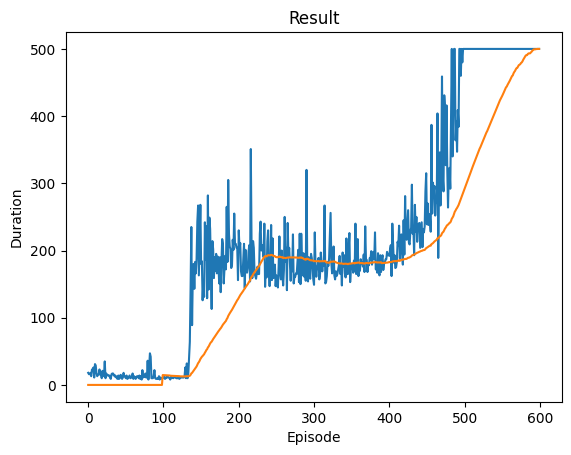

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [12]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item()) # observation.shape (4,)
        reward = torch.tensor([reward], device=device) # shape (1,)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            # shape (1, 4)
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()

        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [19]:
env = gym.make("CartPole-v1", render_mode='human')

# Ensure the model is in evaluation mode
policy_net.eval()

# Initialize the environment and get its state
state, info = env.reset()

done = False

for i in range(700):
    env.render()
    # Select action using the policy network

    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    with torch.no_grad():
        action = policy_net(state).max(1).indices
    
    # Perform the action in the environment
    state, reward, terminated, truncated, _ = env.step(action.item())

    # If the episode is terminated or truncated, reset the environment
    if terminated or truncated:
        state, info = env.reset()
    
env.close()